In [115]:
# Notebook 1: Data Setup and Exploration

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [117]:
# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print(" LendingClub Credit Explainability Project")
print("=" * 50)

 LendingClub Credit Explainability Project


In [119]:
# Step 1: Load the LendingClub Dataset
def load_lendingclub_data():
    """
    Load LendingClub dataset - you'll need to download from Kaggle
    URL: https://www.kaggle.com/datasets/wordsforthewise/lending-club
    """
    try:
        # Try to load the main dataset
        df = pd.read_csv('data/accepted_2007_to_2018Q4.csv.gz', low_memory=False)
        print(f" Dataset loaded successfully: {df.shape}")
        return df
    except FileNotFoundError:
        print(" Dataset not found. Please download from:")
        print("https://www.kaggle.com/datasets/wordsforthewise/lending-club")
        print("Save as: data/accepted_2007_to_2018Q4.csv.gz")
        
        # Create sample synthetic data for development
        print(" Creating synthetic sample data for development...")
        return create_sample_data()

def create_sample_data():
    """Create realistic sample data for development/testing"""
    np.random.seed(42)
    n_samples = 10000
    
    # Generate realistic credit features
    data = {
        'loan_amnt': np.random.normal(15000, 8000, n_samples).clip(1000, 40000),
        'annual_inc': np.random.lognormal(11, 0.5, n_samples).clip(20000, 200000),
        'dti': np.random.normal(18, 8, n_samples).clip(0, 50),
        'fico_range_low': np.random.normal(700, 50, n_samples).clip(300, 850),
        'emp_length': np.random.choice([1, 2, 3, 5, 8, 10], n_samples),
        'home_ownership': np.random.choice(['RENT', 'OWN', 'MORTGAGE'], n_samples, p=[0.4, 0.2, 0.4]),
        'verification_status': np.random.choice(['Verified', 'Source Verified', 'Not Verified'], n_samples),
        'purpose': np.random.choice(['debt_consolidation', 'credit_card', 'home_improvement', 'other'], 
                                  n_samples, p=[0.5, 0.2, 0.15, 0.15]),
        'term': np.random.choice([36, 60], n_samples, p=[0.7, 0.3]),
        'int_rate': np.random.normal(12, 4, n_samples).clip(5, 25)
    }
    
    df = pd.DataFrame(data)
    
    # Create realistic loan grades based on features
    grade_score = (
        (df['fico_range_low'] - 300) / 550 * 0.4 +
        (1 - df['dti'] / 50) * 0.3 +
        (df['annual_inc'] / 200000) * 0.2 +
        np.random.normal(0, 0.1, n_samples) * 0.1
    )
    
    # Convert to grades A-G
    grade_bins = [0, 0.2, 0.35, 0.5, 0.65, 0.8, 0.9, 1.0]
    df['grade'] = pd.cut(grade_score, bins=grade_bins, labels=['G', 'F', 'E', 'D', 'C', 'B', 'A'])
    
    print(f" Created synthetic dataset: {df.shape}")
    return df

In [121]:
# Step 2: Data Preprocessing for Explainability
def preprocess_for_explainability(df, sample_size=50000):
    """
    Preprocess LendingClub data focusing on key features for explainability
    """
    print(f" Preprocessing data...")
    
    # Sample data if too large
    if len(df) > sample_size:
        df = df.sample(n=sample_size, random_state=42)
        print(f" Sampled {sample_size} records for faster processing")
    
    # Key features for credit explainability
    key_features = [
        'loan_amnt', 'annual_inc', 'dti', 'fico_range_low', 'emp_length',
        'home_ownership', 'verification_status', 'purpose', 'term', 'int_rate', 'grade'
    ]
    
    # Keep only available features
    available_features = [col for col in key_features if col in df.columns]
    df_clean = df[available_features].copy()
    
    # Handle missing values
    print(f" Handling missing values...")
    df_clean = df_clean.dropna()
    
    # Feature engineering
    if 'annual_inc' in df_clean.columns and 'loan_amnt' in df_clean.columns:
        df_clean['income_to_loan_ratio'] = df_clean['annual_inc'] / df_clean['loan_amnt']
    
    if 'fico_range_low' in df_clean.columns:
        df_clean['fico_category'] = pd.cut(df_clean['fico_range_low'], 
                                         bins=[0, 580, 670, 740, 800, 850],
                                         labels=['Poor', 'Fair', 'Good', 'Very Good', 'Excellent'])
        # Convert to string to avoid category dtype issues
        df_clean['fico_category'] = df_clean['fico_category'].astype(str)
    
    print(f" Preprocessing complete: {df_clean.shape}")
    print(f" Features: {list(df_clean.columns)}")
    
    return df_clean

In [123]:
# Step 3: Exploratory Data Analysis
def explore_dataset(df):
    """
    Perform EDA focusing on explainability insights
    """
    print(f"\n DATASET OVERVIEW")
    print("=" * 30)
    print(f"Shape: {df.shape}")
    print(f"Features: {list(df.columns)}")
    
    # Target distribution (loan grades)
    if 'grade' in df.columns:
        print(f"\n LOAN GRADE DISTRIBUTION")
        print("-" * 25)
        grade_dist = df['grade'].value_counts().sort_index()
        print(grade_dist)
        print(f"Percentages:")
        print((grade_dist / len(df) * 100).round(1))
        
        # Plot grade distribution
        plt.figure(figsize=(10, 6))
        grade_dist.plot(kind='bar', color='skyblue', alpha=0.8)
        plt.title('Distribution of Loan Grades', fontsize=16, fontweight='bold')
        plt.xlabel('Loan Grade')
        plt.ylabel('Count')
        plt.xticks(rotation=0)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Feature correlations
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 1:
        print(f"\n FEATURE CORRELATIONS")
        print("-" * 20)
        corr_matrix = df[numeric_cols].corr()
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                   square=True, linewidths=0.5)
        plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
    # Key insights for explainability
    print(f"\n KEY INSIGHTS FOR EXPLAINABILITY")
    print("-" * 35)
    
    if 'grade' in df.columns and 'fico_range_low' in df.columns:
        fico_by_grade = df.groupby('grade')['fico_range_low'].agg(['mean', 'std']).round(0)
        print("FICO Score by Grade:")
        print(fico_by_grade)
    
    if 'grade' in df.columns and 'annual_inc' in df.columns:
        income_by_grade = df.groupby('grade')['annual_inc'].agg(['mean', 'median']).round(0)
        print("\nIncome by Grade:")
        print(income_by_grade)
    
    return df

In [125]:
# Step 4: Prepare Data for ML Models
def prepare_ml_data(df, target_col='grade'):
    """
    Prepare data for machine learning models
    """
    print(f"\n PREPARING DATA FOR ML")
    print("=" * 25)
    
    # Separate features and target
    if target_col not in df.columns:
        print(f" Target column '{target_col}' not found")
        return None, None, None, None, None
    
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # Encode categorical variables
    categorical_cols = X.select_dtypes(include=['object']).columns
    label_encoders = {}
    
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"   Data preparation complete")
    print(f"   Training set: {X_train.shape}")
    print(f"   Test set: {X_test.shape}")
    print(f"   Features: {list(X.columns)}")
    
    return X_train, X_test, y_train, y_test, label_encoders

In [127]:
# Step 5: Train Baseline Model
def train_baseline_model(X_train, y_train, X_test, y_test):
    """
    Train a Random Forest model for explanation comparison
    """
    print(f"\n TRAINING RANDOM FOREST MODEL")
    print("=" * 30)
    
    # Train Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    
    rf_model.fit(X_train, y_train)
    
    # Evaluate model
    train_score = rf_model.score(X_train, y_train)
    test_score = rf_model.score(X_test, y_test)
    
    print(f"   Model trained successfully")
    print(f"   Training accuracy: {train_score:.3f}")
    print(f"   Test accuracy: {test_score:.3f}")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\n TOP 10 FEATURE IMPORTANCES")
    print("-" * 25)
    print(feature_importance.head(10).to_string(index=False))
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    top_features = feature_importance.head(10)
    plt.barh(range(len(top_features)), top_features['importance'], color='lightcoral')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 10 Feature Importances (Random Forest)', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return rf_model, feature_importance

In [129]:
# Main execution function
def main():
    """
    Main function to set up the credit explainability project
    """
    print(" Starting LendingClub Credit Explainability Project")
    print("=" * 55)
    
    # Load data
    df = load_lendingclub_data()
    
    if df is not None:
        # Preprocess
        df_clean = preprocess_for_explainability(df)
        
        # Explore
        df_final = explore_dataset(df_clean)
        
        # Prepare for ML
        X_train, X_test, y_train, y_test, encoders = prepare_ml_data(df_final)
        
        if X_train is not None:
            # Train model
            model, feature_importance = train_baseline_model(X_train, y_train, X_test, y_test)
            
            print(f"\n SETUP COMPLETE!")
            print("=" * 20)
            print("Next steps:")
            print("1. Run explanation methods (LIME, SHAP, Counterfactuals)")
            print("2. Compare explanation outputs")
            print("3. Build interactive demo")
            
            return {
                'data': df_final,
                'X_train': X_train, 'X_test': X_test,
                'y_train': y_train, 'y_test': y_test,
                'model': model,
                'encoders': encoders,
                'feature_importance': feature_importance
            }
    
    return None

In [131]:
import lime
import lime.lime_tabular
import shap
from scipy.spatial.distance import cdist

In [133]:
# Plotting setup
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)

In [135]:
print(" Credit Explainability Comparison System")
print("=" * 45)

 Credit Explainability Comparison System


In [137]:
class CreditExplainer:
    """
    Comprehensive explanation system for credit scoring
    Compares LIME, SHAP, and Counterfactual explanations
    """
    
    def __init__(self, model, X_train, X_test, y_train, y_test, feature_names, encoders=None):
        self.model = model
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.feature_names = feature_names
        self.encoders = encoders
        
        # Initialize explainers
        self.lime_explainer = None
        self.shap_explainer = None
        self.setup_explainers()
        
    def setup_explainers(self):
        """Initialize LIME and SHAP explainers"""
        print(" Setting up explainers...")
        
        # LIME Explainer
        self.lime_explainer = lime.lime_tabular.LimeTabularExplainer(
            self.X_train.values,
            feature_names=self.feature_names,
            class_names=['Grade_' + str(i) for i in range(len(np.unique(self.y_train)))],
            mode='classification',
            discretize_continuous=True,
            random_state=42
        )
        
        # SHAP Explainer (TreeExplainer for RandomForest)
        self.shap_explainer = shap.TreeExplainer(self.model)
        
        print(" Explainers ready!")
        
    def get_lime_explanation(self, instance_idx, num_features=10):
        """Get LIME explanation for a specific instance"""
        instance = self.X_test.iloc[instance_idx].values
        
        explanation = self.lime_explainer.explain_instance(
            instance,
            self.model.predict_proba,
            num_features=num_features,
            top_labels=1
        )
        
        # Get the predicted class for this instance
        predicted_class = self.model.predict([instance])[0]
        
        # Extract feature importance - use the first available label
        lime_importance = {}
        available_labels = list(explanation.available_labels())
        
        if available_labels:
            # Use the first available label
            label_to_use = available_labels[0]
            feature_list = explanation.as_list(label=label_to_use)
            
            for feature_idx, importance in feature_list:
                # Clean up feature names
                feature_name = feature_idx.split(' ')[0] if ' ' in feature_idx else feature_idx
                # Try to match with actual feature names
                for fname in self.feature_names:
                    if fname in feature_idx or feature_idx.startswith(fname):
                        lime_importance[fname] = importance
                        break
                else:
                    lime_importance[feature_name] = importance
        
        return lime_importance, explanation
    
    def get_shap_explanation(self, instance_idx):
        """Get SHAP explanation for a specific instance"""
        instance = self.X_test.iloc[instance_idx:instance_idx+1]
        
        shap_values = self.shap_explainer.shap_values(instance)
        
        # Get model prediction to determine which class to use
        prediction = self.model.predict(instance)[0]
        probabilities = self.model.predict_proba(instance)[0]
        predicted_class_idx = np.argmax(probabilities)
        
        # Extract SHAP values for the predicted class
        # Shape is (1, n_features, n_classes)
        if len(shap_values.shape) == 3:
            shap_vals = shap_values[0, :, predicted_class_idx]
        else:
            shap_vals = shap_values[0]
            
        # Create importance dictionary
        shap_importance = dict(zip(self.feature_names, shap_vals))
        
        return shap_importance, shap_values
    
    def get_counterfactual_explanation(self, instance_idx, target_grade=None, max_changes=3):
        """
        Generate counterfactual explanation
        Find minimal changes to flip the prediction
        """
        original_instance = self.X_test.iloc[instance_idx].copy()
        original_pred = self.model.predict([original_instance])[0]
        
        # Map grades to numbers for comparison
        grade_to_num = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6}
        num_to_grade = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G'}
        
        original_grade_num = grade_to_num.get(original_pred, 3)  # Default to 3 if not found
        
        if target_grade is None:
            # Try to improve by one grade (lower number = better grade)
            target_grade_num = max(0, original_grade_num - 1)
            target_grade = num_to_grade[target_grade_num]
        else:
            target_grade_num = grade_to_num.get(target_grade, 2)
        
        print(f" Looking for changes to move from Grade {original_pred} to Grade {target_grade}")
        
        best_counterfactual = None
        min_changes = float('inf')
        
        # Try systematic changes to key features
        key_features = ['dti', 'annual_inc', 'loan_amnt', 'fico_range_low', 'int_rate']
        available_features = [f for f in key_features if f in self.feature_names]
        
        # Generate counterfactuals by modifying features
        for feature in available_features:
            for direction in [-1, 1]:  # decrease, increase
                for magnitude in [0.1, 0.2, 0.5, 1.0]:  # different change sizes
                    modified_instance = original_instance.copy()
                    
                    if feature in ['dti', 'int_rate']:
                        # For ratios, modify by percentage
                        change = original_instance[feature] * magnitude * direction * -1  # opposite for improvement
                        modified_instance[feature] = max(0, original_instance[feature] + change)
                    elif feature in ['annual_inc']:
                        # For income, increase helps
                        change = original_instance[feature] * magnitude * abs(direction)
                        modified_instance[feature] = original_instance[feature] + change
                    elif feature == 'loan_amnt':
                        # For loan amount, decrease helps
                        change = original_instance[feature] * magnitude * direction * -1
                        modified_instance[feature] = max(1000, original_instance[feature] + change)
                    elif feature == 'fico_range_low':
                        # For FICO, increase helps
                        change = 50 * magnitude * abs(direction)
                        modified_instance[feature] = min(850, max(300, original_instance[feature] + change))
                    
                    # Check if this achieves target grade
                    try:
                        new_pred = self.model.predict([modified_instance])[0]
                        new_grade_num = grade_to_num.get(new_pred, original_grade_num)
                        
                        if new_grade_num < original_grade_num:  # Better grade (lower number)
                            changes_made = sum(modified_instance != original_instance)
                            if changes_made < min_changes:
                                min_changes = changes_made
                                best_counterfactual = {
                                    'original': original_instance,
                                    'modified': modified_instance,
                                    'changed_feature': feature,
                                    'change_amount': modified_instance[feature] - original_instance[feature],
                                    'original_grade': original_pred,
                                    'new_grade': new_pred
                                }
                    except:
                        continue
        
        return best_counterfactual
    
    def compare_explanations(self, instance_idx, save_plots=True):
        """
        Compare all three explanation methods for a single instance
        """
        print(f"\n COMPARING EXPLANATIONS FOR INSTANCE {instance_idx}")
        print("=" * 50)
        
        # Get original prediction
        instance = self.X_test.iloc[instance_idx]
        prediction = self.model.predict([instance])[0]
        probability = self.model.predict_proba([instance])[0]
        
        print(f" Original Instance Features:")
        for feature, value in instance.items():
            print(f"   {feature}: {value:.2f}")
        print(f" Predicted Grade: {prediction}")
        print(f" Confidence: {max(probability):.3f}")
        
        # Get explanations
        print(f"\n1 LIME EXPLANATION")
        print("-" * 20)
        lime_importance, lime_exp = self.get_lime_explanation(instance_idx)
        for feature, importance in sorted(lime_importance.items(), key=lambda x: abs(x[1]), reverse=True)[:5]:
            print(f"   {feature}: {importance:.3f}")
        
        print(f"\n2 SHAP EXPLANATION")
        print("-" * 20)
        shap_importance, shap_values = self.get_shap_explanation(instance_idx)
        for feature, importance in sorted(shap_importance.items(), key=lambda x: abs(x[1]), reverse=True)[:5]:
            print(f"   {feature}: {importance:.3f}")
        
        print(f"\n3 COUNTERFACTUAL EXPLANATION")
        print("-" * 25)
        counterfactual = self.get_counterfactual_explanation(instance_idx)
        if counterfactual:
            feature = counterfactual['changed_feature']
            change = counterfactual['change_amount']
            print(f"   To improve to Grade {counterfactual['new_grade']}:")
            print(f"   Change {feature} by {change:.2f}")
            print(f"   ({counterfactual['original'][feature]:.2f} → {counterfactual['modified'][feature]:.2f})")
        else:
            print("   No simple counterfactual found")
        
        # Create comparison visualization
        self.plot_explanation_comparison(instance_idx, lime_importance, shap_importance, counterfactual)
        
        return {
            'instance_idx': instance_idx,
            'prediction': prediction,
            'lime': lime_importance,
            'shap': shap_importance,
            'counterfactual': counterfactual
        }
    
    def plot_explanation_comparison(self, instance_idx, lime_importance, shap_importance, counterfactual):
        """Create visualization comparing all explanation methods"""
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'Explanation Comparison - Instance {instance_idx}', fontsize=16, fontweight='bold')
        
        # 1. LIME Feature Importance
        lime_df = pd.DataFrame(list(lime_importance.items()), columns=['Feature', 'Importance'])
        lime_df = lime_df.sort_values('Importance', key=abs, ascending=False).head(8)
        
        axes[0,0].barh(range(len(lime_df)), lime_df['Importance'], 
                       color=['red' if x < 0 else 'green' for x in lime_df['Importance']])
        axes[0,0].set_yticks(range(len(lime_df)))
        axes[0,0].set_yticklabels(lime_df['Feature'], fontsize=10)
        axes[0,0].set_title('LIME Explanation', fontweight='bold')
        axes[0,0].set_xlabel('Feature Importance')
        axes[0,0].grid(axis='x', alpha=0.3)
        
        # 2. SHAP Feature Importance
        shap_df = pd.DataFrame(list(shap_importance.items()), columns=['Feature', 'Importance'])
        shap_df = shap_df.sort_values('Importance', key=abs, ascending=False).head(8)
        
        axes[0,1].barh(range(len(shap_df)), shap_df['Importance'],
                       color=['red' if x < 0 else 'green' for x in shap_df['Importance']])
        axes[0,1].set_yticks(range(len(shap_df)))
        axes[0,1].set_yticklabels(shap_df['Feature'], fontsize=10)
        axes[0,1].set_title('SHAP Explanation', fontweight='bold')
        axes[0,1].set_xlabel('SHAP Value')
        axes[0,1].grid(axis='x', alpha=0.3)
        
        # 3. Feature Ranking Comparison
        common_features = set(lime_df['Feature']) & set(shap_df['Feature'])
        if common_features:
            lime_ranks = {f: i for i, f in enumerate(lime_df['Feature'])}
            shap_ranks = {f: i for i, f in enumerate(shap_df['Feature'])}
            
            features = list(common_features)
            lime_ranking = [lime_ranks.get(f, len(lime_df)) for f in features]
            shap_ranking = [shap_ranks.get(f, len(shap_df)) for f in features]
            
            axes[1,0].scatter(lime_ranking, shap_ranking, s=100, alpha=0.7)
            for i, feature in enumerate(features):
                axes[1,0].annotate(feature, (lime_ranking[i], shap_ranking[i]), 
                                 xytext=(5, 5), textcoords='offset points', fontsize=8)
            
            axes[1,0].plot([0, max(max(lime_ranking), max(shap_ranking))], 
                          [0, max(max(lime_ranking), max(shap_ranking))], 'r--', alpha=0.5)
            axes[1,0].set_xlabel('LIME Ranking (lower = more important)')
            axes[1,0].set_ylabel('SHAP Ranking (lower = more important)')
            axes[1,0].set_title('Method Agreement (closer to line = more agreement)', fontweight='bold')
            axes[1,0].grid(True, alpha=0.3)
        
        # 4. Counterfactual Visualization
        if counterfactual:
            feature = counterfactual['changed_feature']
            original_val = counterfactual['original'][feature]
            new_val = counterfactual['modified'][feature]
            
            axes[1,1].bar(['Original', 'Counterfactual'], [original_val, new_val], 
                         color=['lightcoral', 'lightgreen'], alpha=0.7)
            axes[1,1].set_title(f'Counterfactual: {feature}', fontweight='bold')
            axes[1,1].set_ylabel(f'{feature} Value')
            
            # Add grade labels
            axes[1,1].text(0, original_val + abs(original_val)*0.1, 
                          f"Grade {counterfactual['original_grade']}", 
                          ha='center', fontweight='bold')
            axes[1,1].text(1, new_val + abs(new_val)*0.1, 
                          f"Grade {counterfactual['new_grade']}", 
                          ha='center', fontweight='bold')
            axes[1,1].grid(axis='y', alpha=0.3)
        else:
            axes[1,1].text(0.5, 0.5, 'No Counterfactual\nFound', 
                          ha='center', va='center', transform=axes[1,1].transAxes,
                          fontsize=14, fontweight='bold')
            axes[1,1].set_title('Counterfactual Explanation', fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    def analyze_method_agreement(self, num_instances=50):
        """
        Analyze agreement between explanation methods across multiple instances
        """
        print(f"\n ANALYZING METHOD AGREEMENT ACROSS {num_instances} INSTANCES")
        print("=" * 60)
        
        agreements = []
        correlations = []
        
        for i in range(min(num_instances, len(self.X_test))):
            # Get explanations
            lime_importance, _ = self.get_lime_explanation(i)
            shap_importance, _ = self.get_shap_explanation(i)
            
            # Find common features
            common_features = set(lime_importance.keys()) & set(shap_importance.keys())
            if len(common_features) < 3:
                continue
                
            # Calculate correlation between importance rankings
            lime_vals = [lime_importance[f] for f in common_features]
            shap_vals = [shap_importance[f] for f in common_features]
            
            correlation = np.corrcoef(lime_vals, shap_vals)[0,1]
            if not np.isnan(correlation):
                correlations.append(correlation)
            
            # Check top-3 feature agreement
            lime_top3 = set(sorted(lime_importance.items(), key=lambda x: abs(x[1]), reverse=True)[:3])
            lime_top3 = set([x[0] for x in lime_top3])
            
            shap_top3 = set(sorted(shap_importance.items(), key=lambda x: abs(x[1]), reverse=True)[:3])
            shap_top3 = set([x[0] for x in shap_top3])
            
            agreement = len(lime_top3 & shap_top3) / 3.0
            agreements.append(agreement)
        
        # Report results
        avg_agreement = np.mean(agreements) if agreements else 0
        avg_correlation = np.mean(correlations) if correlations else 0
        
        print(f" Average Top-3 Feature Agreement: {avg_agreement:.2%}")
        print(f" Average Feature Importance Correlation: {avg_correlation:.3f}")
        
        # Plot agreement distribution
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        
        if agreements:
            ax1.hist(agreements, bins=20, alpha=0.7, color='skyblue', edgecolor='black')
            ax1.axvline(avg_agreement, color='red', linestyle='--', linewidth=2, 
                       label=f'Mean: {avg_agreement:.2%}')
            ax1.set_xlabel('Agreement Score (0 = no agreement, 1 = perfect agreement)')
            ax1.set_ylabel('Frequency')
            ax1.set_title('LIME vs SHAP: Top-3 Feature Agreement', fontweight='bold')
            ax1.legend()
            ax1.grid(axis='y', alpha=0.3)
        
        if correlations:
            ax2.hist(correlations, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
            ax2.axvline(avg_correlation, color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {avg_correlation:.3f}')
            ax2.set_xlabel('Correlation Coefficient (-1 to 1)')
            ax2.set_ylabel('Frequency')
            ax2.set_title('LIME vs SHAP: Feature Importance Correlation', fontweight='bold')
            ax2.legend()
            ax2.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        return {
            'avg_agreement': avg_agreement,
            'avg_correlation': avg_correlation,
            'agreements': agreements,
            'correlations': correlations
        }


In [159]:
# Demo function to run everything
def run_credit_explainability_demo(project_data):
    """
    Run the complete credit explainability demonstration
    """
    print(" Starting Credit Explainability Demo")
    print("=" * 40)
    
    # Extract data from setup
    X_train = project_data['X_train']
    X_test = project_data['X_test'] 
    y_train = project_data['y_train']
    y_test = project_data['y_test']
    model = project_data['model']
    encoders = project_data['encoders']
    
    # Initialize explainer
    explainer = CreditExplainer(
        model=model,
        X_train=X_train,
        X_test=X_test,
        y_train=y_train,
        y_test=y_test,
        feature_names=list(X_train.columns),
        encoders=encoders
    )

    print(f"\n DEMO SCENARIOS")
    print("=" * 20)
    
    # Scenario 1: High-risk loan (find any loan for demo)
    high_risk_idx = 0  # Just use first instance for demo
    print(f" Scenario 1: High-Risk Loan (Instance {high_risk_idx})")
    pred = model.predict([X_test.iloc[high_risk_idx]])[0]
    print(f"   Predicted grade: {pred}")
    result1 = explainer.compare_explanations(high_risk_idx)
    
    # Scenario 2: Different loan analysis
    borderline_idx = 5
    print(f"\n Scenario 2: Different Loan (Instance {borderline_idx})")
    pred2 = model.predict([X_test.iloc[borderline_idx]])[0]
    print(f"   Predicted grade: {pred2}")
    result2 = explainer.compare_explanations(borderline_idx)
    
    
    # Scenario 3: Method Agreement Analysis
    print(f"\n Scenario 3: Method Agreement Analysis")
    agreement_analysis = explainer.analyze_method_agreement(num_instances=30)
    
    print(f"\n DEMO COMPLETE!")
    print("=" * 20)
    print("Key Insights:")
    print(f"• LIME-SHAP Agreement: {agreement_analysis['avg_agreement']:.1%}")
    print(f"• Feature Correlation: {agreement_analysis['avg_correlation']:.3f}")
    print("• Counterfactuals provide actionable insights")
    print("• Method disagreement highlights uncertainty")
    
    return explainer, agreement_analysis

In [161]:
# Install required packages if needed
def install_requirements():
    """Install required packages for explanation methods"""
    try:
        import lime
        import shap
        print(" All required packages already installed")
    except ImportError:
        print(" Installing required packages...")
        import subprocess
        subprocess.run(["pip", "install", "lime", "shap"])
        print(" Installation complete")

In [163]:
# Main execution
if __name__ == "__main__":
    # Make sure packages are installed
    install_requirements()
    
    print(" Ready to run explainability demo!")
    print("Use: explainer, results = run_credit_explainability_demo(project_data)")

 All required packages already installed
 Ready to run explainability demo!
Use: explainer, results = run_credit_explainability_demo(project_data)


 Starting LendingClub Credit Explainability Project
 Dataset not found. Please download from:
https://www.kaggle.com/datasets/wordsforthewise/lending-club
Save as: data/accepted_2007_to_2018Q4.csv.gz
 Creating synthetic sample data for development...
 Created synthetic dataset: (10000, 11)
 Preprocessing data...
 Handling missing values...
 Preprocessing complete: (10000, 13)
 Features: ['loan_amnt', 'annual_inc', 'dti', 'fico_range_low', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'term', 'int_rate', 'grade', 'income_to_loan_ratio', 'fico_category']

 DATASET OVERVIEW
Shape: (10000, 13)
Features: ['loan_amnt', 'annual_inc', 'dti', 'fico_range_low', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'term', 'int_rate', 'grade', 'income_to_loan_ratio', 'fico_category']

 LOAN GRADE DISTRIBUTION
-------------------------
grade
G       0
F      14
E    2326
D    6853
C     803
B       4
A       0
Name: count, dtype: int64
Percentages:
grade
G     0.0
F

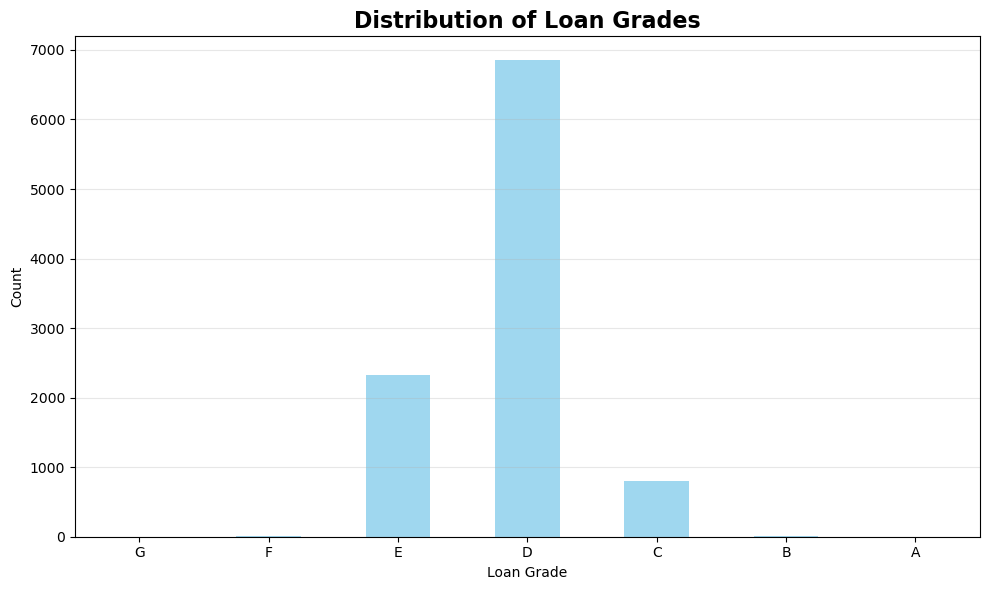


 FEATURE CORRELATIONS
--------------------


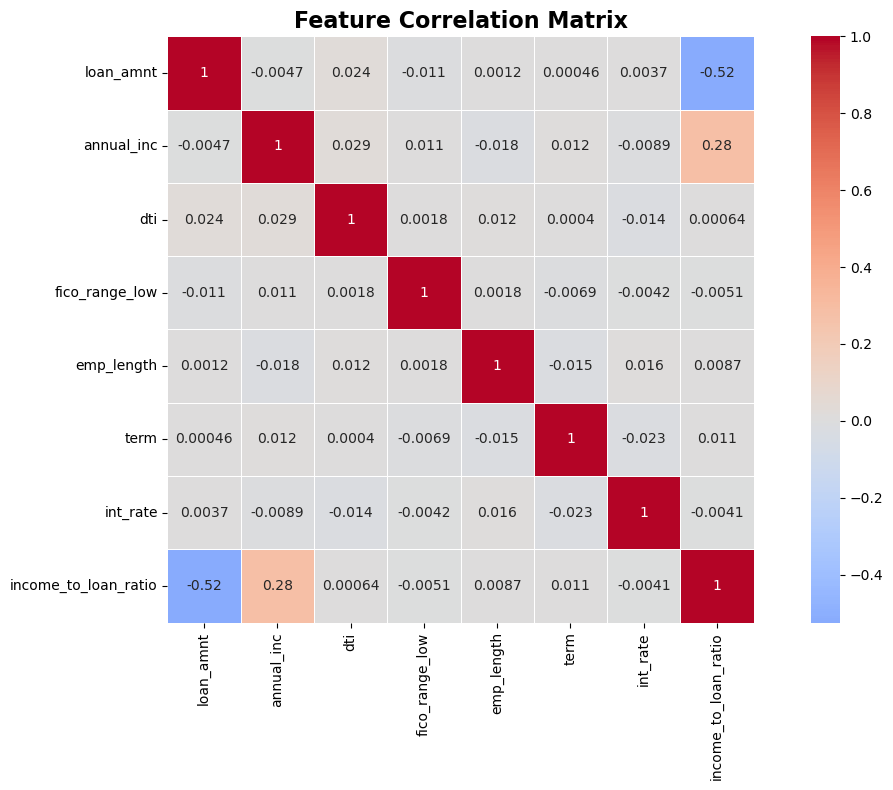


 KEY INSIGHTS FOR EXPLAINABILITY
-----------------------------------
FICO Score by Grade:
        mean   std
grade             
G        NaN   NaN
F      592.0  26.0
E      665.0  44.0
D      706.0  45.0
C      748.0  46.0
B      775.0  42.0
A        NaN   NaN

Income by Grade:
           mean    median
grade                    
G           NaN       NaN
F       39575.0   34265.0
E       50459.0   46341.0
D       68767.0   62329.0
C      112543.0  108266.0
B      199506.0  200000.0
A           NaN       NaN

 PREPARING DATA FOR ML
   Data preparation complete
   Training set: (8000, 12)
   Test set: (2000, 12)
   Features: ['loan_amnt', 'annual_inc', 'dti', 'fico_range_low', 'emp_length', 'home_ownership', 'verification_status', 'purpose', 'term', 'int_rate', 'income_to_loan_ratio', 'fico_category']

 TRAINING RANDOM FOREST MODEL
   Model trained successfully
   Training accuracy: 0.972
   Test accuracy: 0.912

 TOP 10 FEATURE IMPORTANCES
-------------------------
             feature

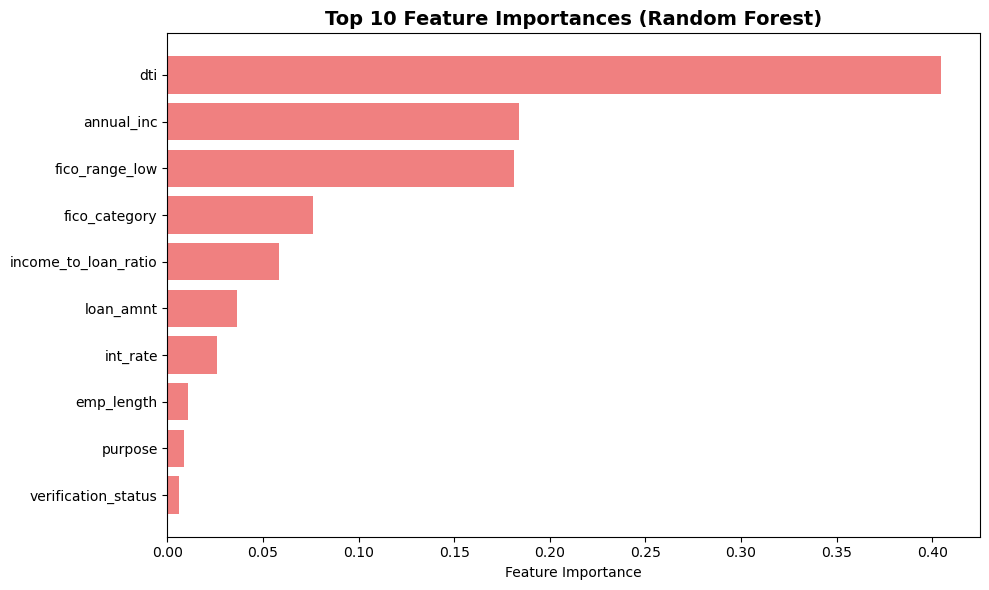


 SETUP COMPLETE!
Next steps:
1. Run explanation methods (LIME, SHAP, Counterfactuals)
2. Compare explanation outputs
3. Build interactive demo


In [165]:
# Run the setup
if __name__ == "__main__":
    project_data = main()

 Starting Credit Explainability Demo
 Setting up explainers...
 Explainers ready!

 DEMO SCENARIOS
 Scenario 1: High-Risk Loan (Instance 0)
   Predicted grade: D

 COMPARING EXPLANATIONS FOR INSTANCE 0
 Original Instance Features:
   loan_amnt: 24102.21
   annual_inc: 53394.07
   dti: 18.81
   fico_range_low: 725.44
   emp_length: 10.00
   home_ownership: 1.00
   verification_status: 1.00
   purpose: 1.00
   term: 36.00
   int_rate: 12.26
   income_to_loan_ratio: 2.22
   fico_category: 2.00
 Predicted Grade: D
 Confidence: 0.960

1 LIME EXPLANATION
--------------------
   fico_range_low: 0.056
   dti: 0.054
   fico_category: 0.035
   home_ownership: 0.024
   income_to_loan_ratio: -0.023

2 SHAP EXPLANATION
--------------------
   dti: 0.109
   fico_range_low: 0.092
   fico_category: 0.040
   annual_inc: 0.022
   income_to_loan_ratio: 0.008

3 COUNTERFACTUAL EXPLANATION
-------------------------
 Looking for changes to move from Grade D to Grade C
   No simple counterfactual found


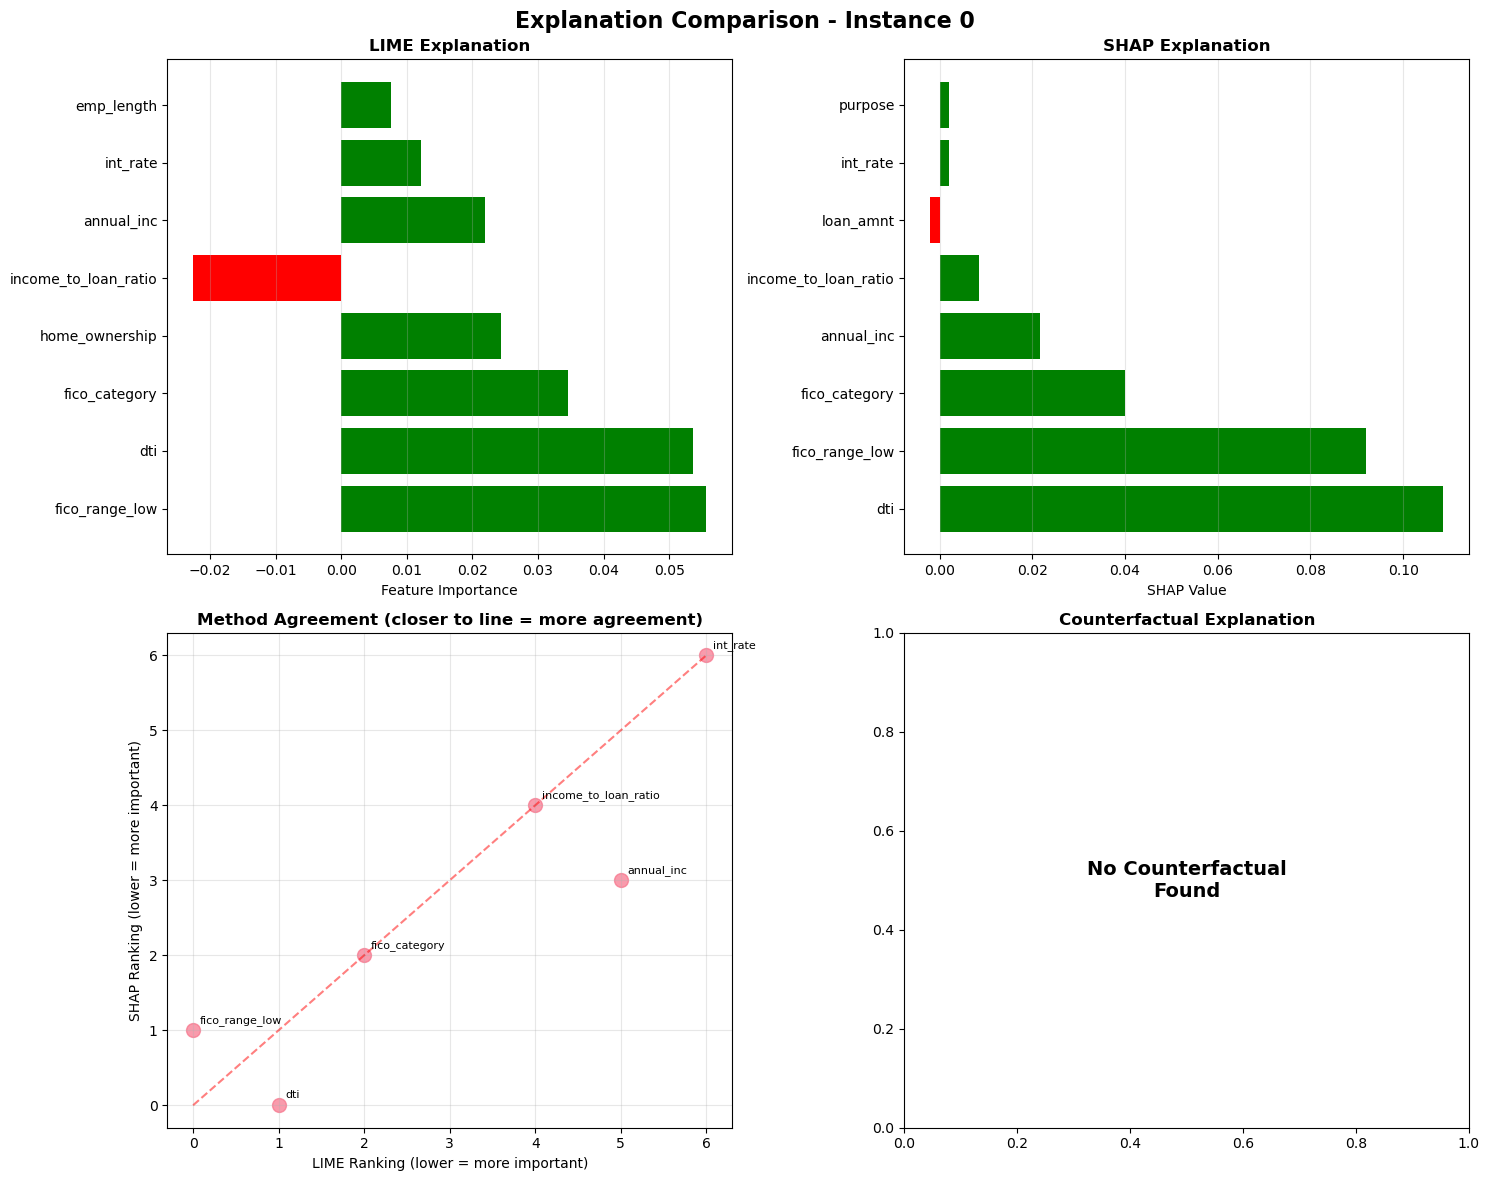


 Scenario 2: Different Loan (Instance 5)
   Predicted grade: D

 COMPARING EXPLANATIONS FOR INSTANCE 5
 Original Instance Features:
   loan_amnt: 18157.37
   annual_inc: 63365.02
   dti: 17.81
   fico_range_low: 708.96
   emp_length: 3.00
   home_ownership: 2.00
   verification_status: 2.00
   purpose: 0.00
   term: 36.00
   int_rate: 8.74
   income_to_loan_ratio: 3.49
   fico_category: 2.00
 Predicted Grade: D
 Confidence: 0.953

1 LIME EXPLANATION
--------------------
   dti: 0.148
   fico_range_low: 0.077
   annual_inc: 0.060
   fico_category: 0.054
   income_to_loan_ratio: 0.025

2 SHAP EXPLANATION
--------------------
   dti: 0.111
   fico_range_low: 0.061
   annual_inc: 0.038
   fico_category: 0.037
   income_to_loan_ratio: 0.013

3 COUNTERFACTUAL EXPLANATION
-------------------------
 Looking for changes to move from Grade D to Grade C
   No simple counterfactual found


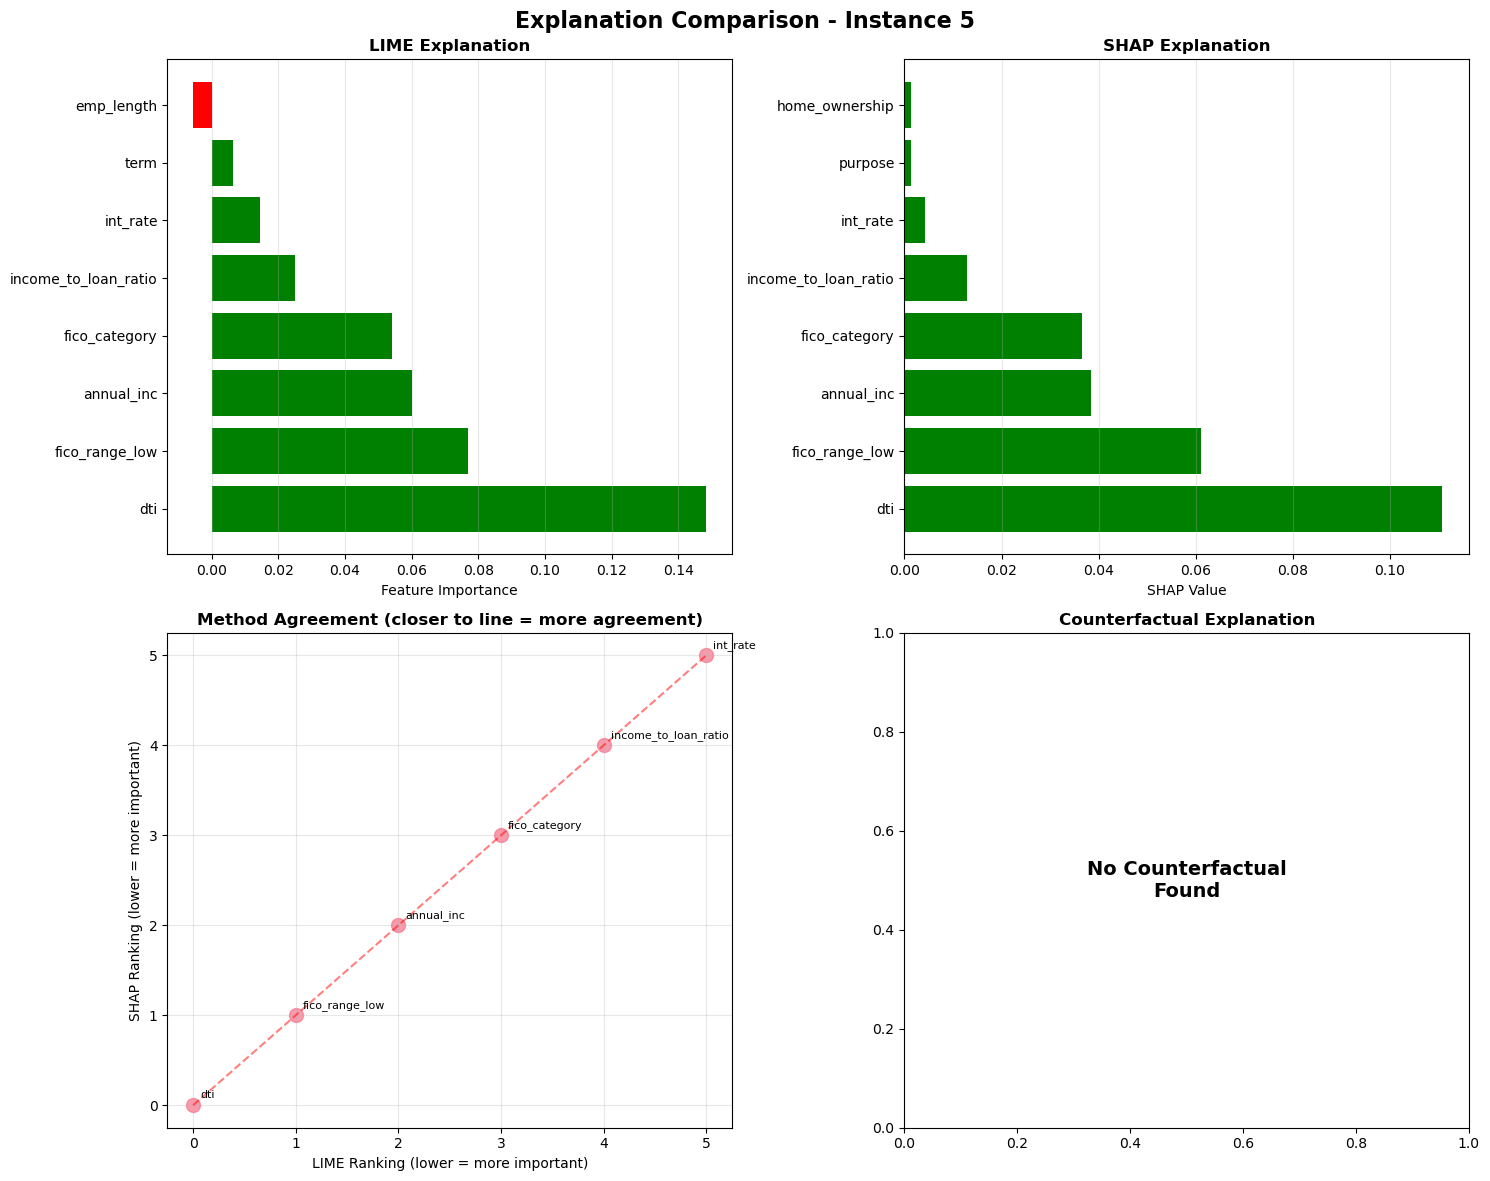


 Scenario 3: Method Agreement Analysis

 ANALYZING METHOD AGREEMENT ACROSS 30 INSTANCES
 Average Top-3 Feature Agreement: 72.22%
 Average Feature Importance Correlation: 0.672


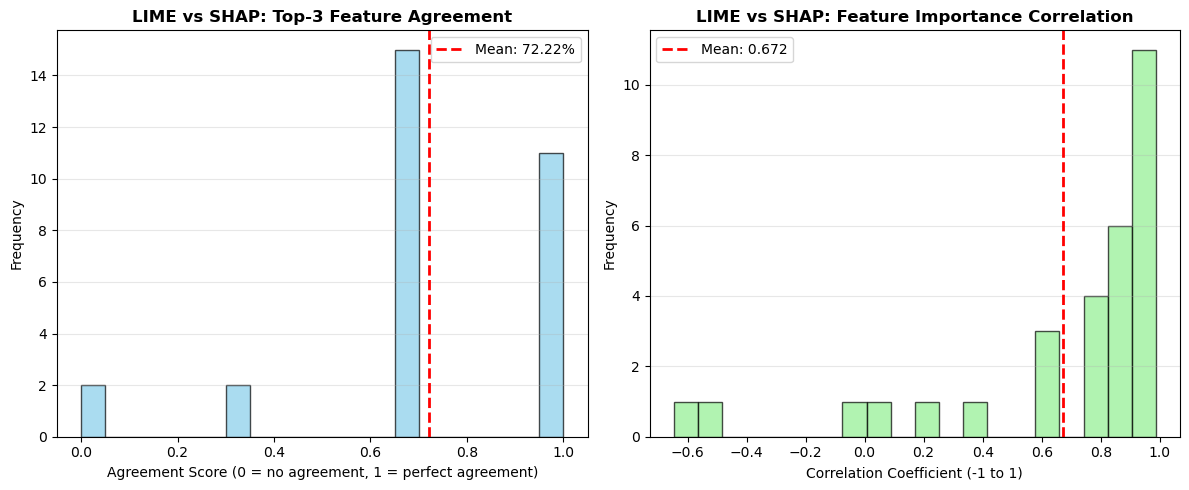


 DEMO COMPLETE!
Key Insights:
• LIME-SHAP Agreement: 72.2%
• Feature Correlation: 0.672
• Counterfactuals provide actionable insights
• Method disagreement highlights uncertainty


In [167]:
explainer, results = run_credit_explainability_demo(project_data)